# Comparing radar rainfall estimates and gauge measurements

This notebook facilitates the comparison of radar rainfall estimates taken at gauge locations in the previous notebook.

Import libraries.

In [1]:
%pylab inline
import pandas as pd
import pytz

Populating the interactive namespace from numpy and matplotlib


Read the radar estimate files and combine them into one dataframe.

In [2]:
df_radar_17 = pd.read_csv('KLOT_20210611_RainAmounts_at_CookCountyGauges.csv')
df_radar_18 = pd.read_csv('KLOT_20210612_RainAmounts_at_CookCountyGauges.csv')

df_radar = pd.concat([df_radar_17,df_radar_18])

Read the gauge observation files.

In [3]:
# load CCN gauge observations
#CCN_gauge_observations_fname = 'C:/Users/irene/Documents/Work/Data/Cook_County/WaterYear2013.csv'
CCN_gauge_observations_fname = '/home/ac.jcorner/Rainfall/WaterYear2013_hourlyprecip.csv'
df_gauge = pd.read_csv(CCN_gauge_observations_fname,header=0)

Since we are dealing with UTC times from the radar and local (Chicago) times for the rain rauges, we need to take care of the timezone concerns. The radar estimate files loaded above has a column for local times, but in comparing `datetime` objects we need to make sure both the date-time columns in both dataframes are timezone aware.

In [4]:
# set the timezone
timezone = pytz.timezone("America/Chicago")

Set the `DatetimeIndex` of `df_radar`.

In [5]:
df_radar = df_radar.set_index(pd.DatetimeIndex(df_radar['Datetime']))

Set the `DatetimeIndex` of `df_gauge`

In [6]:
# Convert datetime column to datetime objects
df_gauge['Datetime'] = pd.to_datetime(df_gauge['Date/Time'])
# make the datetime column timezone-aware
df_gauge['Datetime'] = df_gauge['Datetime'].dt.tz_localize(timezone,ambiguous='NaT',nonexistent ='NaT')
# set the datetime index
df_gauge = df_gauge.set_index(pd.DatetimeIndex(df_gauge['Datetime']))

Filter both dataframes to the event period.

In [7]:
mask_gauge = (df_gauge['Datetime'] >= '2013-04-16 19:00:00') & (df_gauge['Datetime'] <= '2013-04-18 17:00:00')
mask_radar = (df_radar['Datetime'] >= '2013-04-16 19:00:00') & (df_radar['Datetime'] <= '2013-04-18 18:00:00')
df_gauge_cs = df_gauge.loc[mask_gauge]
df_radar_cs = df_radar.loc[mask_radar]

Remove some unnecessary columns.

In [8]:
df_gauge_cs = df_gauge_cs.drop(labels=['Date/Time','Unnamed: 26','Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30'], axis=1)
df_radar_cs = df_radar_cs.drop(labels=['Unnamed: 0','DateTime'], axis=1)

Get the hourly mean of ALL the gauges.

In [9]:
hourly_mean_allgauges = df_gauge_cs.mean(axis=1)

<ipython-input-9-743e98294a29>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  hourly_mean_allgauges = df_gauge_cs.mean(axis=1)


Get the hourly mean of the radar estimates.

In [14]:
cols = df_radar_cs.columns.drop(['DateTime(UTC)','Datetime'])
# force the values to numeric first
#hourly_mean_allradars = df_radar_cs[cols].apply(pd.to_numeric, errors='coerce').resample('H',label='right',how='sum').mean(axis=1)
hourly_mean_allradars = df_radar_cs[cols].apply(pd.to_numeric, errors='coerce').resample('H',label='right').mean()

Plot!

ValueError: x and y must be the same size

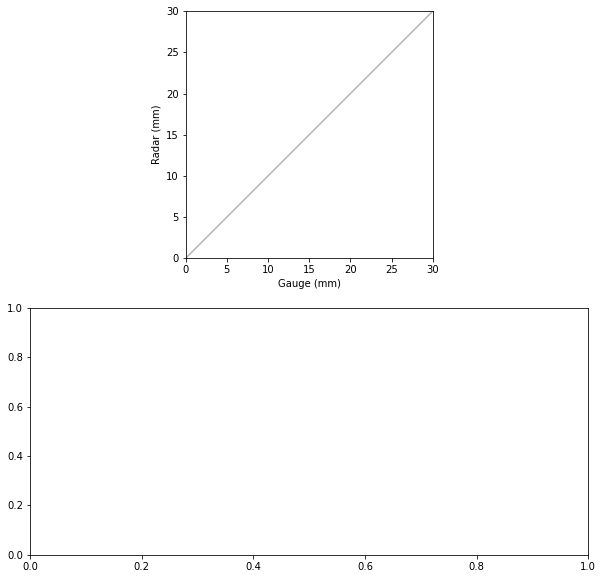

In [15]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211,aspect='equal')
ax1.plot((0,60),(0,60),color='0.7',zorder=-.5)
ax1.set_xlabel('Gauge (mm)')
ax1.set_ylabel('Radar (mm)')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(212)

for gagenum in df_gauge.keys()[1:26]:
    time = df_gauge_cs.index
    gaugevals = df_gauge_cs[gagenum].values*25.4 # convert inches to mm
    radarvals = pd.to_numeric(df_radar_cs[gagenum],errors='coerce').resample('H',label='right').sum()
    ax1.scatter(gaugevals,radarvals,s=20,facecolor='k',edgecolor='None',alpha=0.4)
    ax2.plot_date(time,gaugevals,'b-',alpha=0.1)
    ax2.plot_date(time,radarvals,'r-',alpha=0.1)
ax2.set_title('Rainfall amount within the hour (mm)',loc='left')

ax2.plot_date(time,hourly_mean_allgauges.values*25.4, 'b-', label='Gauge')
ax2.plot_date(time,hourly_mean_allradars, 'r-', label='Radar')
ax2.legend()


For only one gauge:

ValueError: x and y must have same first dimension, but have shapes (47,) and (0,)

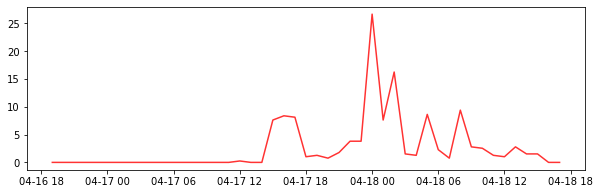

In [12]:
gaugeid = 'G18'

plt.figure(figsize=(10,3))
gaugevals = df_gauge_cs[gaugeid].values*25.4
radarvals = pd.to_numeric(df_radar_cs[gaugeid],errors='coerce').resample('H').sum()
plt.plot_date(time,gaugevals,'r-',alpha=0.8, label='Gauge')
plt.plot_date(time,radarvals,'b-',alpha=0.8, label='Radar')
plt.legend()